In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

import netCDF4 as nc
import glob

from functions.plot_metrics import plot_metrics
from functions.plot_metrics_one import plot_metrics_one
from functions import calc_metrics

2024-05-06 11:40:20.419419: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-06 11:40:20.458239: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 11:40:20.458261: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 11:40:20.459135: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-06 11:40:20.466717: I tensorflow/core/platform/cpu_feature_guar

In [2]:
data_water=parse.parse('cloudrm3_water_newsurf.dat')
data_clear=parse.parse('cloudrm3_clear_newsurf.dat')
data_ice=parse.parse('cloudrm3_ice_newsurf.dat')
data_mixed=parse.parse('cloudrm3_mixed_newsurf.dat')

#data_water=parse.parse('cloudrm2_water.dat')
#data_clear=parse.parse('cloudrm2_clear.dat')
#data_ice=parse.parse('cloudrm2_ice.dat')
#data_mixed=parse.parse('cloudrm2_mixed.dat')

#Concatinate all datasets
data_all=pd.concat([data_water,data_clear,data_ice,data_mixed])


data_all=data_all.drop(columns=['Cloud_B01','Clear_B01'])
data_all=hf.dumb_down_surface(data_all)
data_all=data_all.reset_index()
data_all=data_all.drop(columns=('index'))

df=data_all.copy()

#X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
#           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13','Sun_Zenith_Angle']
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B08A','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Sun_Zenith_Angle']
#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
#y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05',
#              'Clear_B06','Clear_B07','Clear_B08', 'Clear_B09',
#              'Clear_B10','Clear_B11','Clear_B12','Clear_B13']
y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05',
              'Clear_B06','Clear_B07','Clear_B08', 'Clear_B08A',
              'Clear_B09','Clear_B10','Clear_B11','Clear_B12']

In [3]:
main_filepath='pytorch_models/final_model_shadow_edition_10ens_trans'
n_ensemble=10
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))

#X_test=pd.read_csv(main_filepath+'/xtest.csv',index_col=0)
#y_test=pd.read_csv(main_filepath+'/ytest.csv',index_col=0)
X_test=pd.read_csv(main_filepath+'/data/X_test.csv',index_col=0)
y_test=pd.read_csv(main_filepath+'/data/y_test.csv',index_col=0)
y_true=y_test.to_numpy()
#y_true=df.iloc[y_test.index][clear_labels]

In [4]:
from cot_train.utils import StatCollector, MLP5, mlp_inference
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_load_paths=['cot_model_new_surf/0/model_it_2000000','cot_model_new_surf/1/model_it_2000000',
                  'cot_model_new_surf/2/model_it_2000000','cot_model_new_surf/3/model_it_2000000',
                  'cot_model_new_surf/4/model_it_2000000']

input_dim = 13
output_dim = 1

models_cot=[]
for model_path in model_load_paths:
    model_cot = MLP5(input_dim, output_dim, apply_relu=True)
    model_cot.load_state_dict(torch.load(model_path, map_location=device))
    model_cot.to(device)
    models_cot.append(model_cot)


#means=[0.534958,0.538317,0.532992,0.629737,0.826885,0.859306,0.803385,0.880321,0.408178,0.066565,0.428241,0.301306,58.076266]
#stds=[0.218962,0.188747,0.236514,0.185751,0.169492,0.170012,0.162448,0.171793,0.237684,0.096908,0.309903,0.202586,15.602082]

means=[0.538923,0.530993,0.579427,0.630218,0.759563,0.807696,0.767415,0.839607,0.402664,0.066681,0.442786,0.344600,58.065838]
stds=[0.199267,0.175733,0.179156,0.165408,0.157317,0.157984,0.151002,0.158407,0.232892,0.096684,0.313212,0.220723,15.569941]

preds = 0
inputs=(X_test[X_labels].to_numpy()-means)/stds
image_input_tens=torch.Tensor(inputs).to(device)

for model_cot in models_cot:
    curr_preds=model_cot(image_input_tens)/len(models_cot)
    preds=preds+curr_preds
pred_cot=preds.cpu().data.numpy()*50 #unnormalise
#X_test['COT']=pred_cot[:,0]
#X_labels.append('COT')
X_test=X_test[X_labels]

In [5]:
#X_labels.append('Clear')
#X_labels.append('Thin')
#X_labels.append('Thick')

In [6]:
clear_indices=X_test[df.loc[X_test.index]['COT']>0].index

In [7]:
X_test_tmp=X_test.copy()

In [8]:
df.loc[X_test.index]['COT']>0

117388     True
141493     True
40561      True
106710     True
46013      True
          ...  
3812       True
137904     True
89892     False
90164     False
42984      True
Name: COT, Length: 20000, dtype: bool

In [9]:
X_test_tmp[(df.loc[X_test.index]['COT']>0).values].index

Index([117388, 141493,  40561, 106710,  46013,  25347,  13262, 111811,  34663,
       140398,
       ...
       176710,  23386, 128328, 112050, 169716, 103798, 188609,   3812, 137904,
        42984],
      dtype='int64', length=14945)

In [10]:
X_test_tmp=X_test_tmp.reset_index()
clear_indices=X_test_tmp[(df.loc[X_test.index]['COT']>0).values].index

In [11]:
X_test = X_test + np.random.randn(np.shape(X_test)[0],np.shape(X_test)[1]) * np.mean(X_test.to_numpy()[:,0:np.shape(X_test)[1]],axis=0)*0.03
#X_test.iloc[clear_indices,0:14] = X_test.iloc[clear_indices,0:14] + np.random.randn(len(clear_indices),np.shape(X_test)[1]) * np.mean(X_test.to_numpy()[:,0:14],axis=0)*0.03

In [12]:
np.shape(X_test.to_numpy())

(20000, 13)

In [13]:
X_test

,Cloud_B02,Cloud_B03,Cloud_B04,Cloud_B05,Cloud_B06,Cloud_B07,Cloud_B08,Cloud_B08A,Cloud_B09,Cloud_B10,Cloud_B11,Cloud_B12,Sun_Zenith_Angle
117388,0.371106,0.402493,0.430491,0.471654,0.757639,0.876143,0.896366,0.871795,0.443923,-0.001634,0.155403,0.137869,34.383468
141493,0.534789,0.446356,0.451905,0.441007,0.479544,0.481310,0.401509,0.536747,0.012552,-0.001756,0.082709,0.052982,77.982665
40561,0.352717,0.380292,0.417905,0.361104,0.530710,0.635199,0.519865,0.670304,0.010392,-0.002750,0.348516,0.180661,78.475202
106710,0.326061,0.373825,0.490095,0.485671,0.843222,0.974886,0.873059,1.001766,0.053928,0.004530,0.804090,0.509778,41.081300
46013,0.629159,0.575134,0.629020,0.682864,0.669039,0.659999,0.665402,0.695329,0.448759,0.081718,0.481001,0.357498,59.558762
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3812,0.496941,0.511440,0.545253,0.690182,0.870653,0.924041,0.890455,0.955841,0.786541,0.144243,0.726289,0.519703,32.743673
137904,0.698181,0.778943,0.816193,0.764434,0.853610,0.872197,0.847889,0.909006,0.701941,0.205669,0.073419,0.105418,44.576601
89892,0.160972,0.187150,0.224459,0.258970,0.359089,0.461566,0.404050,0.533224,0.028801,-0.004954,0.592293,0.420473,38.002046
90164,0.351870,0.336789,0.491509,0.571588,0.631461,0.735819,0.682459,0.759323,0.357298,-0.004629,0.771830,0.656860,82.063326


In [14]:
for i,model in enumerate(models):
    if i==0:
        pred_y=model.predict(X_test.to_numpy())
    else:   
        pred_y=pred_y+model.predict(X_test.to_numpy())
pred_y=pred_y/len(models)

#X_tmp=np.zeros((np.shape(X_test.to_numpy())[0],np.shape(X_test.to_numpy())[1],9))
#for i in range(np.shape(X_tmp)[2]):
#    X_tmp[:,:,i]=X_test.to_numpy()

#pred_y=X_tmp-pred_y #For cloud estimation

In [15]:
models[0].model

QuantileNetworkMM(
  (linear): Sequential(
    (0): Linear(in_features=13, out_features=200, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=200, out_features=200, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=200, out_features=200, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=200, out_features=36, bias=True)
  )
  (softplus): Softplus(beta=1, threshold=20)
)

In [16]:
tmp=models[0]
loss=tmp.train_loss.data.cpu().numpy()
np.argmin(loss[loss>0])

362

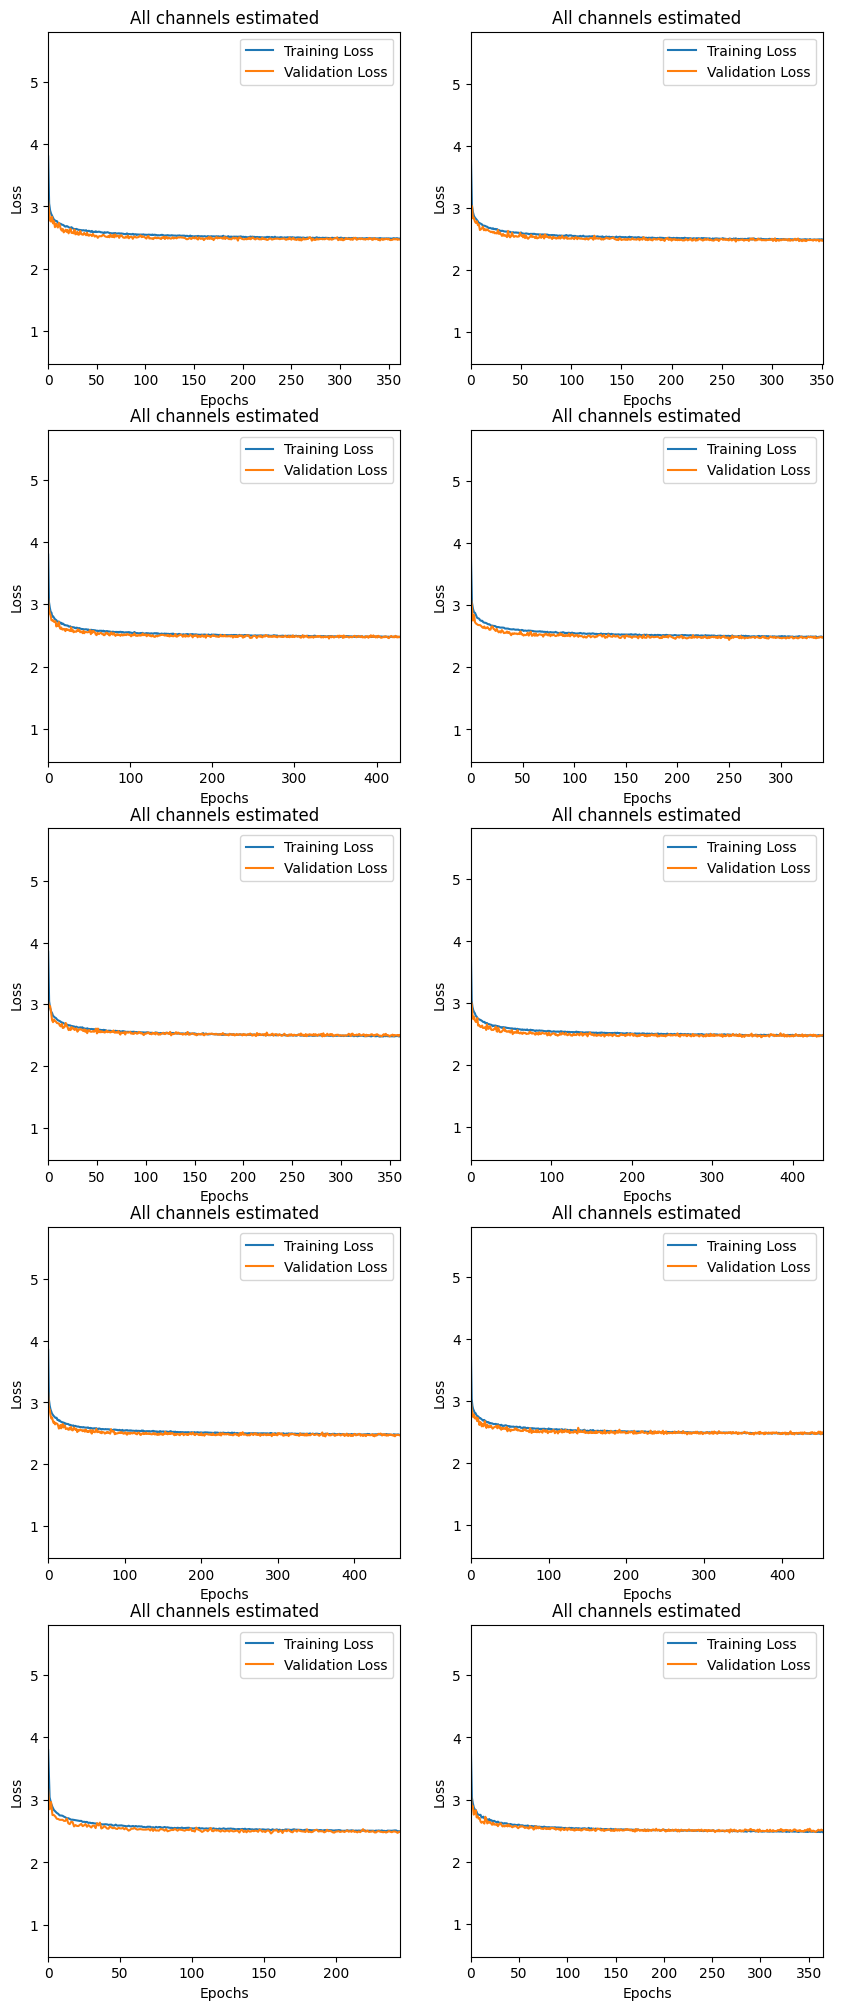

In [17]:
nmodels=len(models)
ncols=2
nrows=int(np.ceil(nmodels/ncols))
plt.rcParams["figure.figsize"] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)
for i,ax in enumerate(axs.ravel()):
    if i<nmodels:
        train_loss=models[i].train_loss.data.cpu().numpy()
        train_loss_l0=train_loss[train_loss>0]
        val_loss=models[i].val_loss.data.cpu().numpy()
        val_loss_l0=val_loss[val_loss>0]
        ax.plot(train_loss)
        ax.plot(val_loss)
        ax.set_title("All channels estimated")
        ax.legend(['Training Loss','Validation Loss'])
        ax.set_xlim(0,np.max([np.argmin(train_loss_l0),np.argmin(val_loss_l0)]))
        ax.set_ylim(np.min(train_loss_l0)-2,np.max(train_loss_l0)+2)
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Loss")

In [18]:
np.shape(pred_y)

(20000, 12, 3)

In [19]:
np.shape(y_test)

(20000, 12)

/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/edgelab/filip/SEEX30_Cloud_Fog/SEEX30_Cloud_Fog/Cloud_rm/functions/plot_metrics_one.py:194: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  axs[f_i].errorbar(x=np.linspace(0,len(y_pred_sort_samp[i][:,index_median]),len(y_pred_sort_samp[i][:,index_median]))


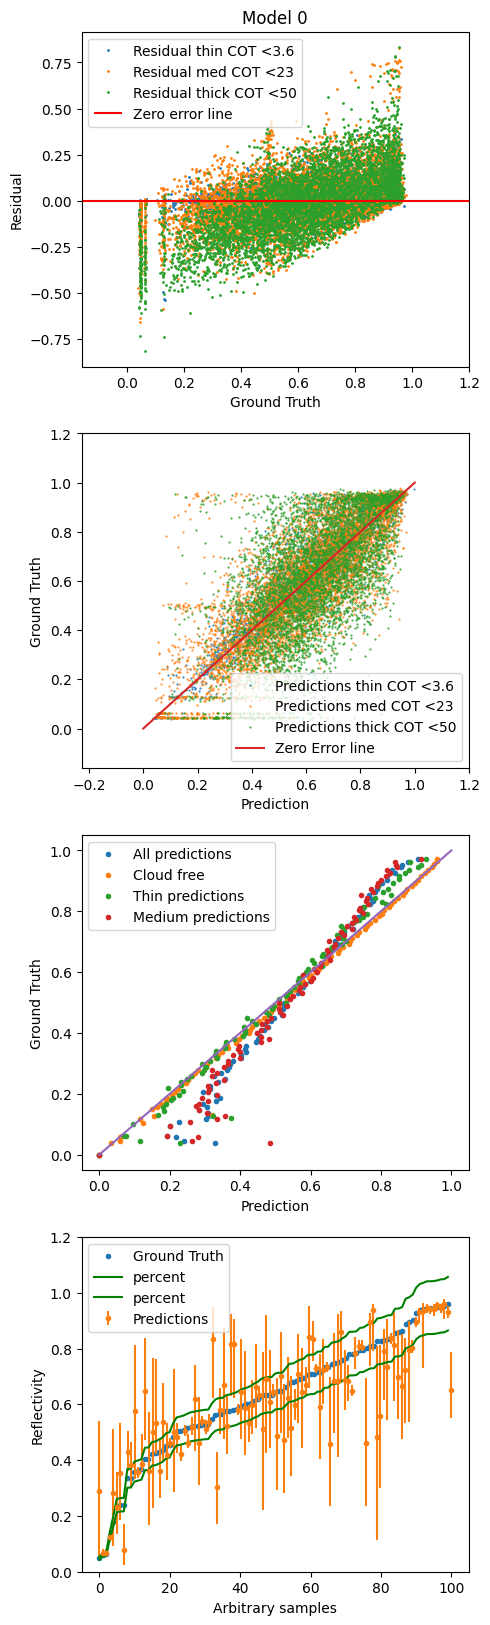

In [20]:
plt.rcParams["figure.figsize"] = [5, 5*4]
figs,axs,mses,r2s,psnrs,quantrates,quantcrosses = plot_metrics_one([models],
                                                                [X_test],
                                                                [y_test],
                                                                [pred_y],
                                                                df,
                                                                samples=100,
                                                                is_ensemble=True,
                                                                index_median=1)

In [21]:
#Indices for different COT
cot_thin=3.6
cot_med=23
cot_thick=50

#Get indexes for optical thin, med and thick
test_indices=X_test.index
df_tmp=df.iloc[test_indices]

#Reset index for future indexing
df_tmp=df_tmp.reset_index()
df_tmp=df_tmp.drop(columns=["index"])

indices_zero=df_tmp[df_tmp['COT']==0].index
indices_thin=df_tmp[(df_tmp['COT']<=cot_thin)&df_tmp['COT']>0].index
indices_med=df_tmp[(df_tmp['COT']>cot_thin)&(df_tmp['COT']<=cot_med)].index
indices_thick=df_tmp[df_tmp['COT']>cot_med].index

/tmp/ipykernel_144185/3855761502.py:32: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  axs[0,0].errorbar(x=np.linspace(0,len(y_pred_sort_samp[:,index_median]),len(y_pred_sort_samp[:,index_median])),
/tmp/ipykernel_144185/3855761502.py:59: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  axs[0,1].errorbar(x=np.linspace(0,len(y_pred_sort_samp[:,index_median]),len(y_pred_sort_samp[:,index_median])),
/tmp/ipykernel_144185/3855761502.py:85: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  axs[1,0].errorbar(x=np.linspace(0,len(y_pred_sort_samp[:,index_median]),len(y_pred_sort_samp[:,index_median])),
/tmp/ipykernel_144185/3855761502.py:111: UserWarning: marker 

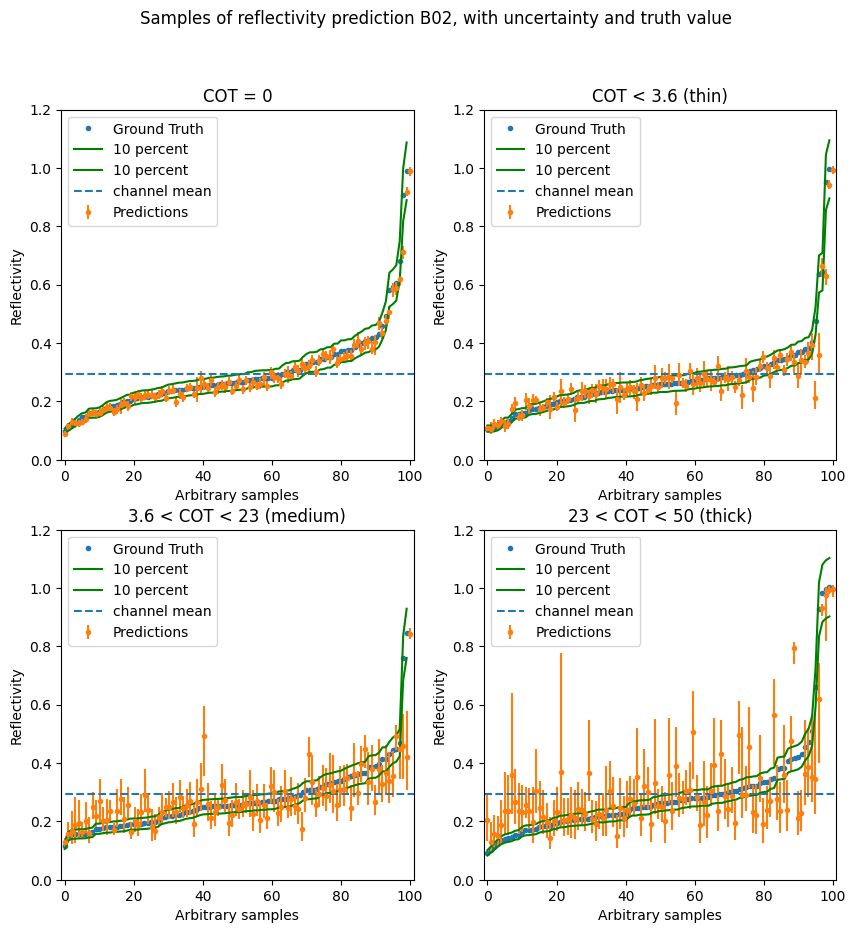

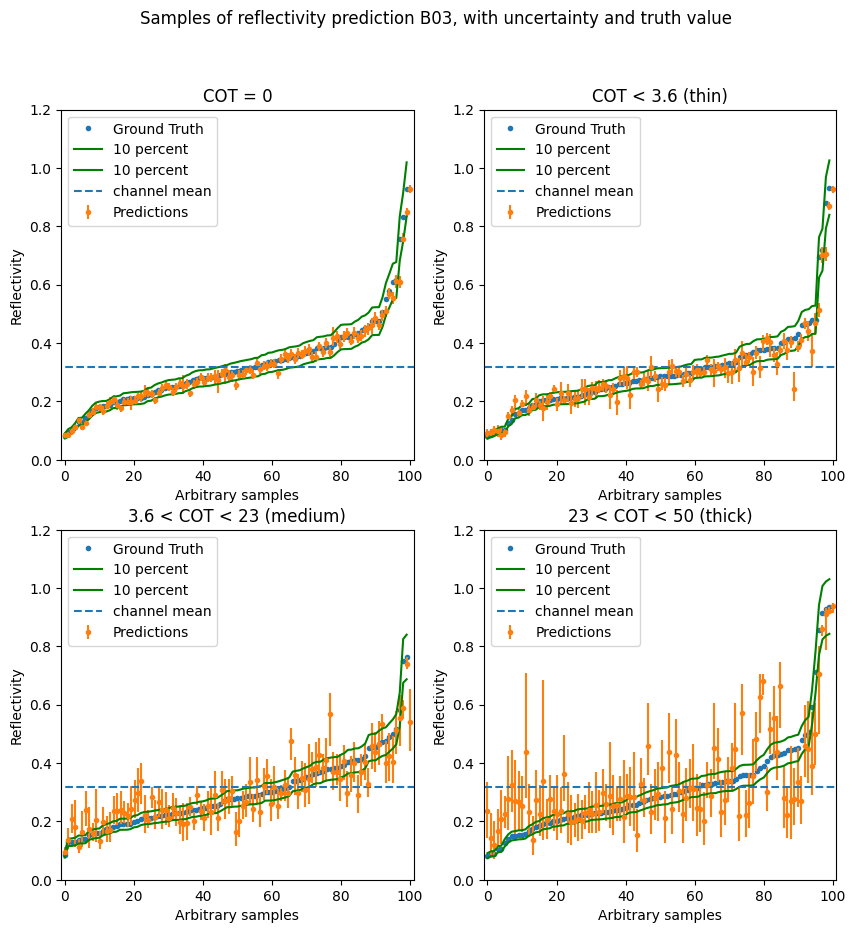

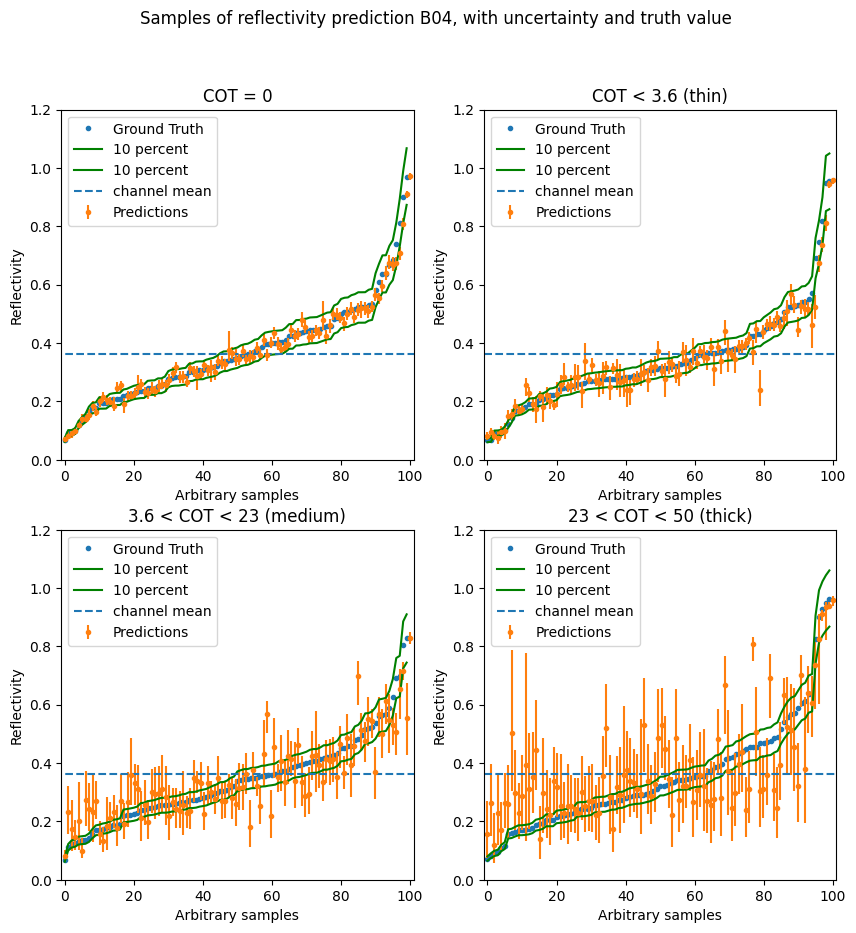

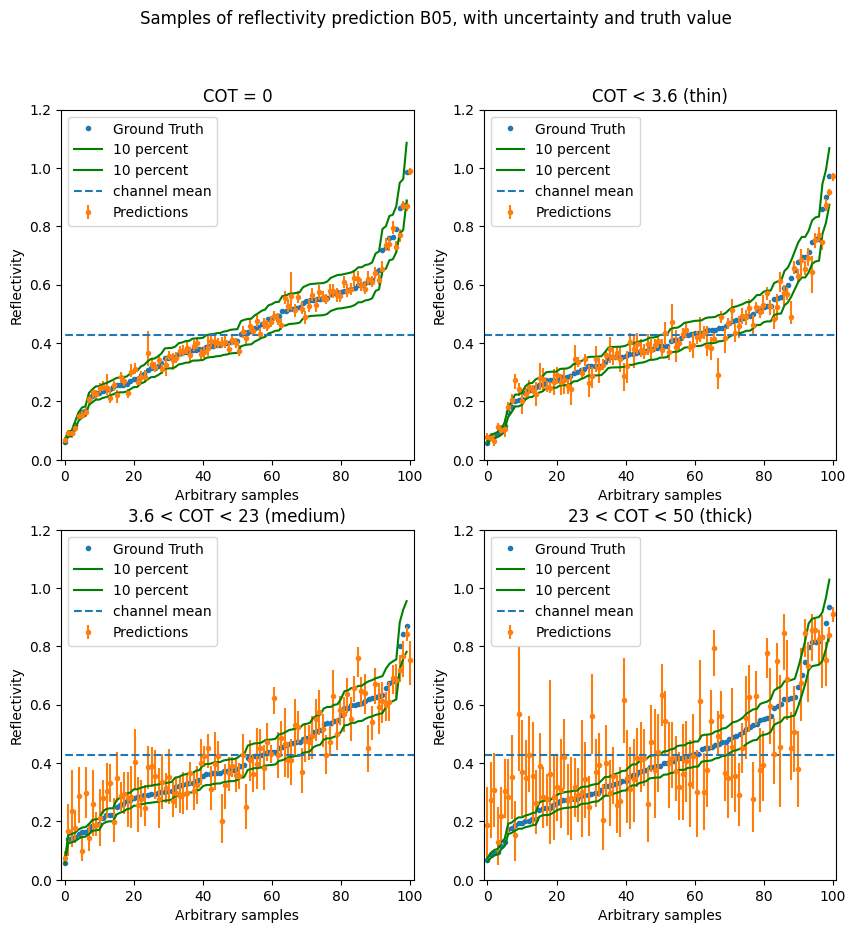

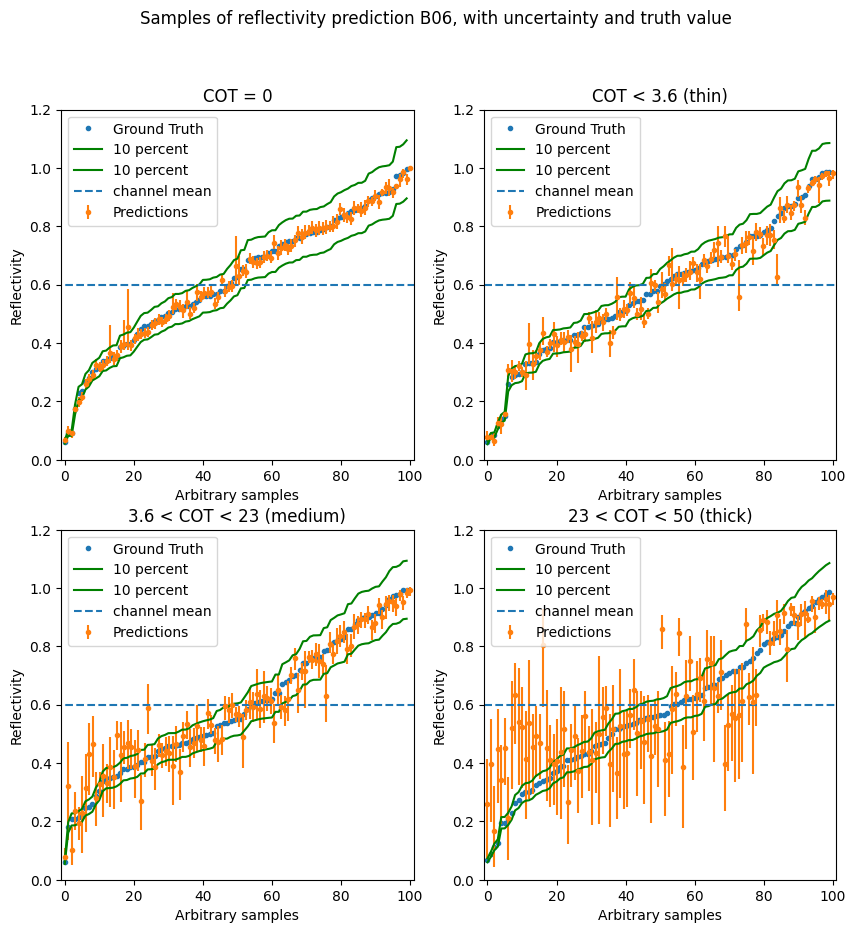

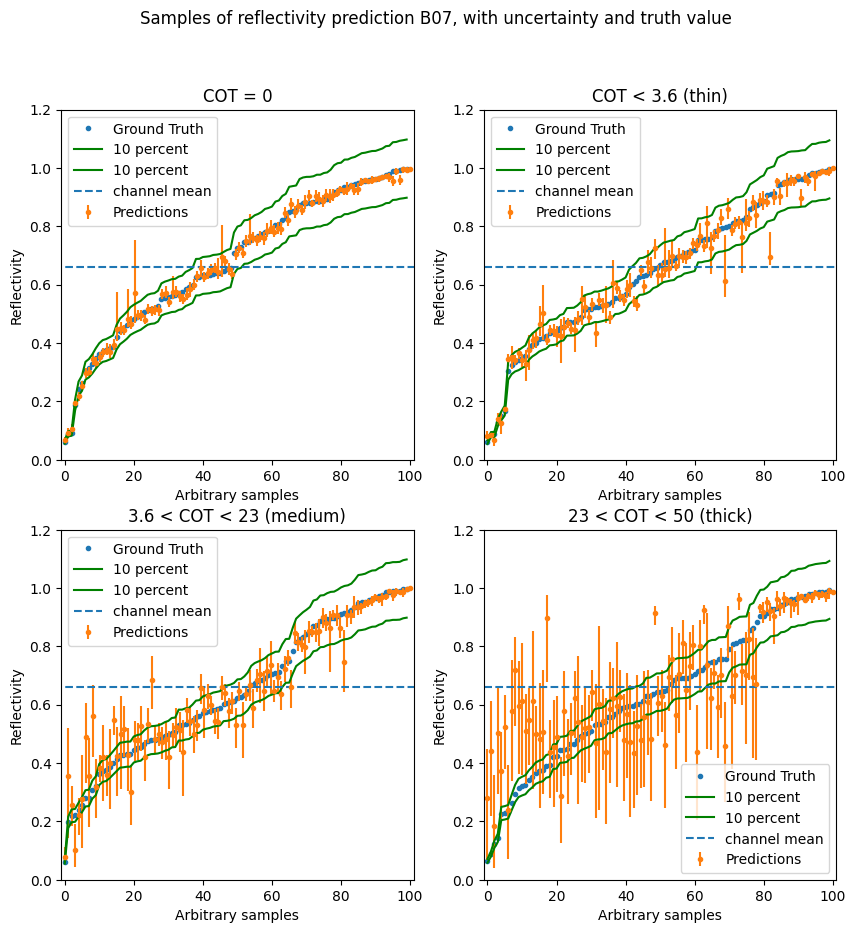

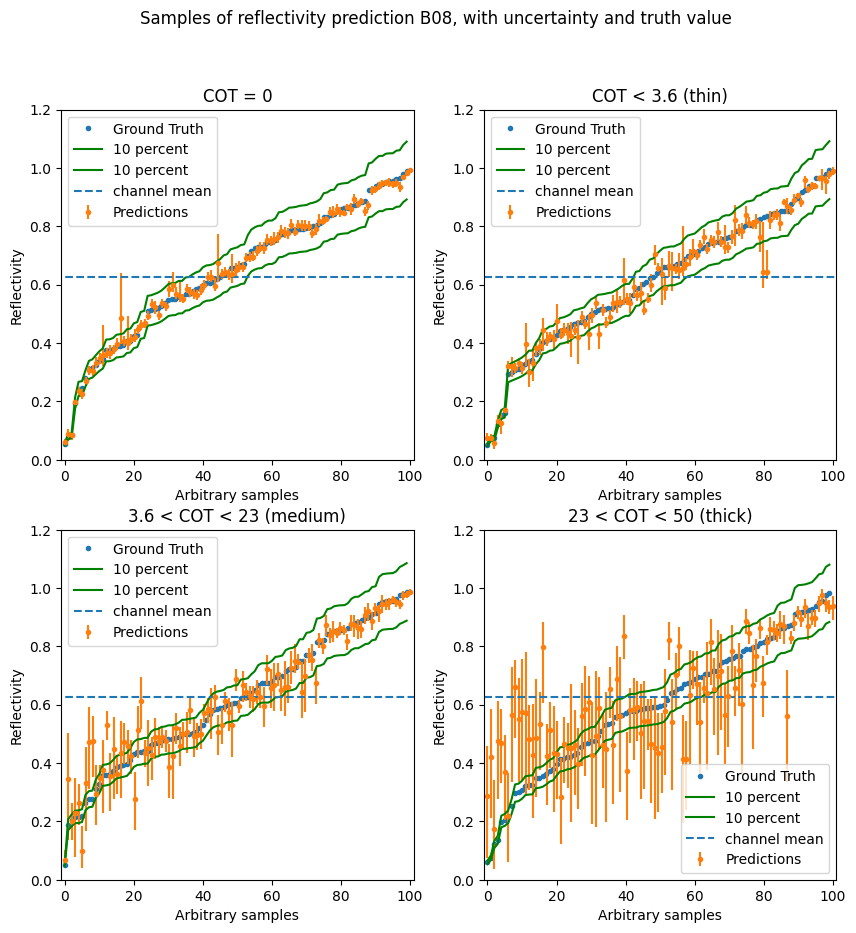

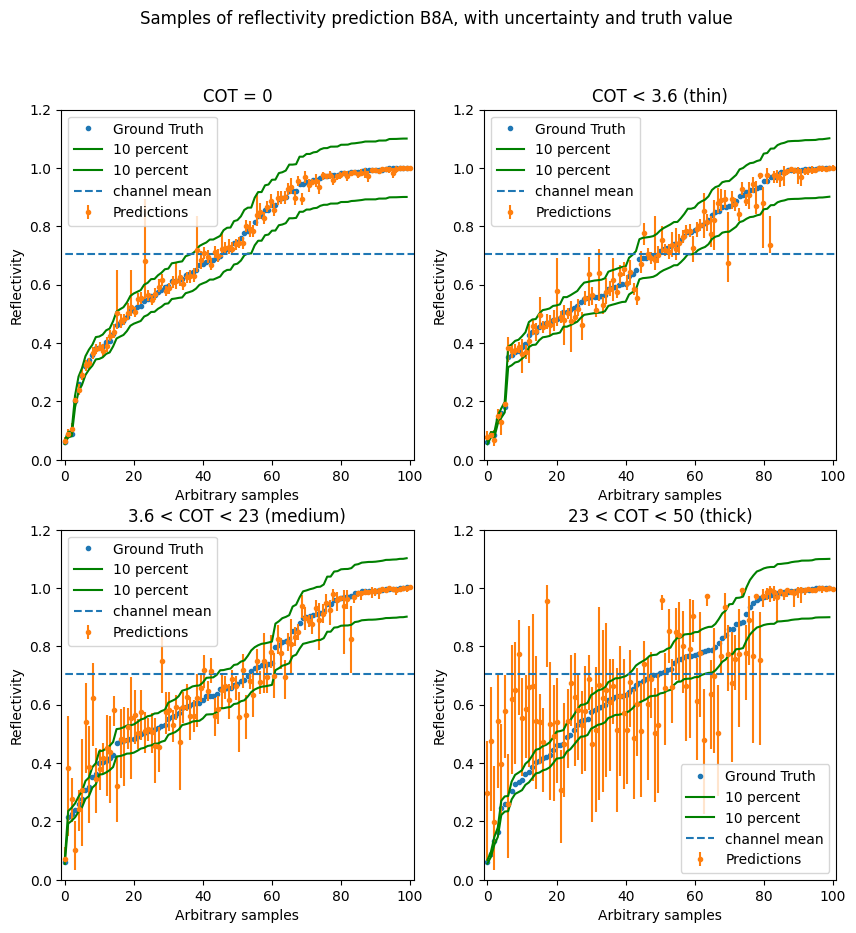

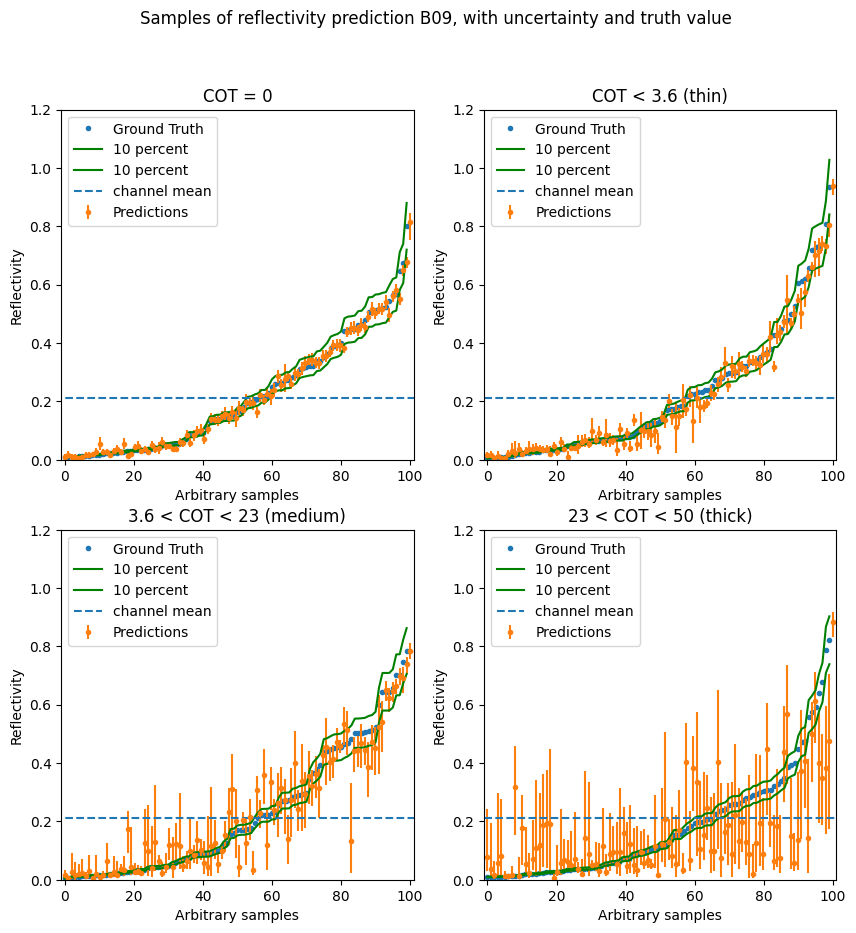

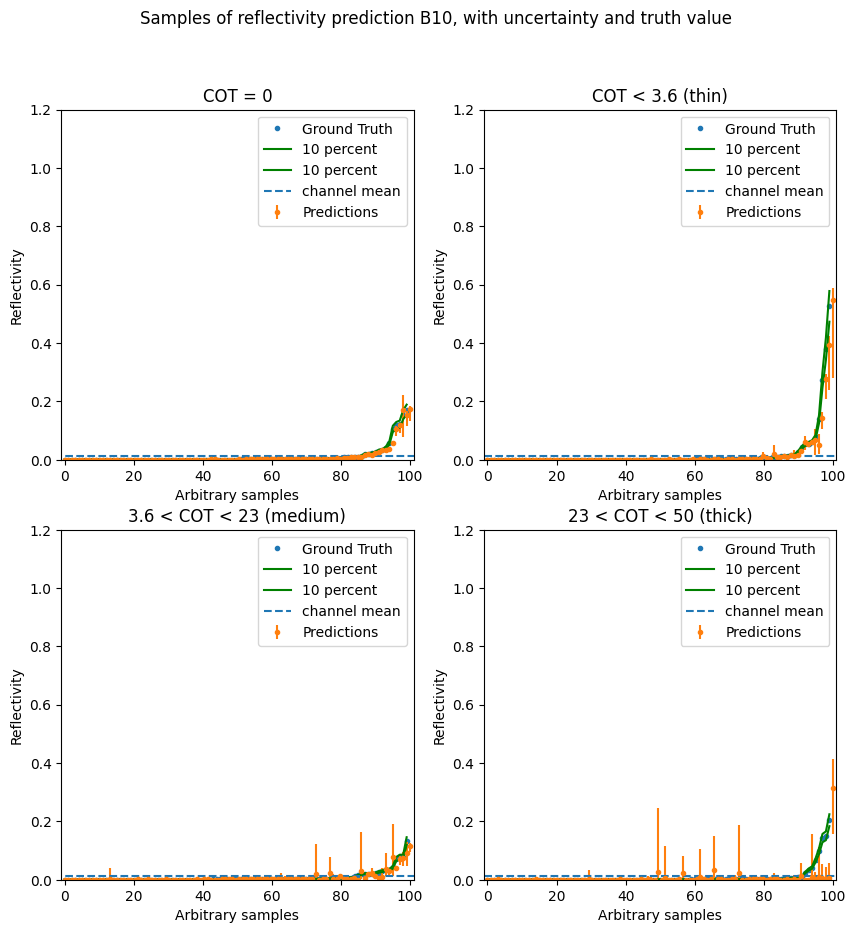

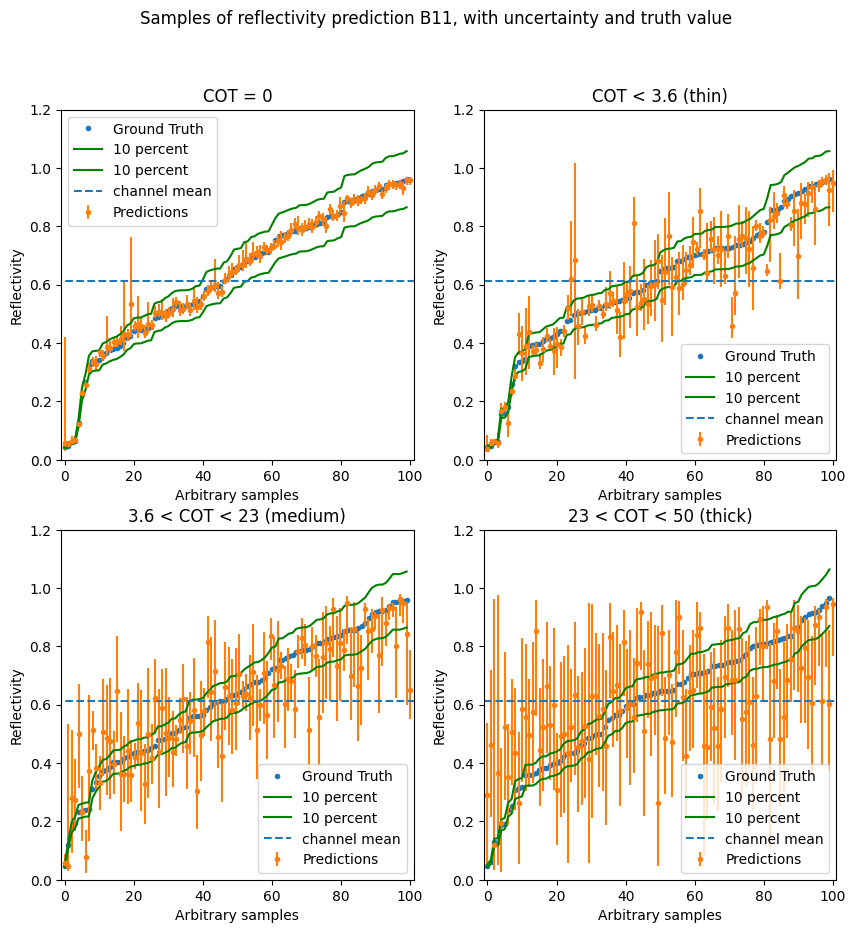

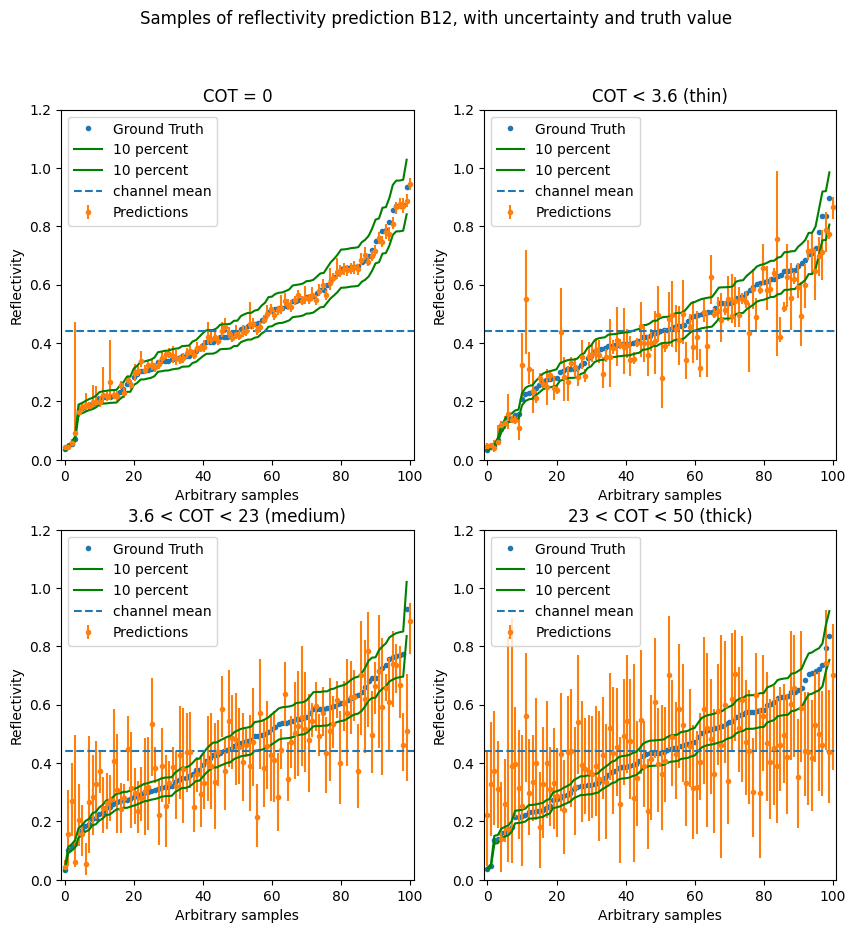

In [22]:

plt.rcParams["figure.figsize"] = [10, 10]
for band in range(12):
    fig, axs=plt.subplots(ncols=2,nrows=2)
    samples=100
    index_median=1
    #sort=np.argsort(y_true)
    #y_true_sort=y_true[sort]
    #y_pred_sort=pred_y[sort]
    y_true_11=y_true[:,band]
    pred_y_11=pred_y[:,band,:]

    y_true_11_mean=np.mean(y_true_11)

    y_true_11_zero=y_true_11[indices_zero]
    y_true_11_thin=y_true_11[indices_thin]
    y_true_11_med=y_true_11[indices_med]
    y_true_11_thick=y_true_11[indices_thick]

    pred_y_11_zero=pred_y_11[indices_zero]
    pred_y_11_thin=pred_y_11[indices_thin]
    pred_y_11_med=pred_y_11[indices_med]
    pred_y_11_thick=pred_y_11[indices_thick]


    ## ZERO COT ##
    y_samp=y_true_11_zero[:samples]
    sort=np.argsort(y_samp)
    y_true_sort_samp=y_samp[sort]
    y_pred_sort_samp=pred_y_11_zero[:samples][sort]
    # Plot the values
    axs[0,0].plot(y_true_sort_samp,'.',label='Ground Truth')
    axs[0,0].errorbar(x=np.linspace(0,len(y_pred_sort_samp[:,index_median]),len(y_pred_sort_samp[:,index_median])),
                y=y_pred_sort_samp[:,index_median],
                yerr=[np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,0]),
                    np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,-1])],
                        marker='.',fmt='.',label='Predictions')

    percent=0.1
    percent_line=np.zeros((len(y_true_sort_samp),2))
    percent_line[:,0]=y_true_sort_samp-y_true_sort_samp*percent
    percent_line[:,1]=y_true_sort_samp+y_true_sort_samp*percent
    axs[0,0].plot(percent_line,'g',label='10 percent')
    axs[0,0].hlines(y_true_11_mean,xmin=-100,xmax=samples+20,linestyles='dashed',label='channel mean')
    axs[0,0].set_xlabel("Arbitrary samples")
    axs[0,0].set_ylabel("Reflectivity")
    axs[0,0].set_ylim((0,1.2))
    axs[0,0].set_xlim((-1,samples+1))
    axs[0,0].legend()
    axs[0,0].set_title("COT = 0")



    y_samp=y_true_11_thin[:samples]
    sort=np.argsort(y_samp)
    y_true_sort_samp=y_samp[sort]
    y_pred_sort_samp=pred_y_11_thin[:samples][sort]
    # Plot the values
    axs[0,1].plot(y_true_sort_samp,'.',label='Ground Truth')
    axs[0,1].errorbar(x=np.linspace(0,len(y_pred_sort_samp[:,index_median]),len(y_pred_sort_samp[:,index_median])),
                y=y_pred_sort_samp[:,index_median],
                yerr=[np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,0]),
                    np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,-1])],
                        marker='.',fmt='.',label='Predictions')

    percent=0.1
    percent_line=np.zeros((len(y_true_sort_samp),2))
    percent_line[:,0]=y_true_sort_samp-y_true_sort_samp*percent
    percent_line[:,1]=y_true_sort_samp+y_true_sort_samp*percent
    axs[0,1].plot(percent_line,'g',label='10 percent')
    axs[0,1].hlines(y_true_11_mean,xmin=-100,xmax=samples+20,linestyles='dashed',label='channel mean')
    axs[0,1].set_xlabel("Arbitrary samples")
    axs[0,1].set_ylabel("Reflectivity")
    axs[0,1].set_ylim((0,1.2))
    axs[0,1].set_xlim((-1,samples+1))
    axs[0,1].legend()
    axs[0,1].set_title("COT < 3.6 (thin)")


    y_samp=y_true_11_med[:samples]
    sort=np.argsort(y_samp)
    y_true_sort_samp=y_samp[sort]
    y_pred_sort_samp=pred_y_11_med[:samples][sort]
    # Plot the values
    axs[1,0].plot(y_true_sort_samp,'.',label='Ground Truth')
    axs[1,0].errorbar(x=np.linspace(0,len(y_pred_sort_samp[:,index_median]),len(y_pred_sort_samp[:,index_median])),
                y=y_pred_sort_samp[:,index_median],
                yerr=[np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,0]),
                    np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,-1])],
                        marker='.',fmt='.',label='Predictions')

    percent=0.1
    percent_line=np.zeros((len(y_true_sort_samp),2))
    percent_line[:,0]=y_true_sort_samp-y_true_sort_samp*percent
    percent_line[:,1]=y_true_sort_samp+y_true_sort_samp*percent
    axs[1,0].plot(percent_line,'g',label='10 percent')
    axs[1,0].hlines(y_true_11_mean,xmin=-100,xmax=samples+20,linestyles='dashed',label='channel mean')
    axs[1,0].set_xlabel("Arbitrary samples")
    axs[1,0].set_ylabel("Reflectivity")
    axs[1,0].set_ylim((0,1.2))
    axs[1,0].set_xlim((-1,samples+1))
    axs[1,0].legend()
    axs[1,0].set_title("3.6 < COT < 23 (medium)")


    y_samp=y_true_11_thick[:samples]
    sort=np.argsort(y_samp)
    y_true_sort_samp=y_samp[sort]
    y_pred_sort_samp=pred_y_11_thick[:samples][sort]
    # Plot the values
    axs[1,1].plot(y_true_sort_samp,'.',label='Ground Truth')
    axs[1,1].errorbar(x=np.linspace(0,len(y_pred_sort_samp[:,index_median]),len(y_pred_sort_samp[:,index_median])),
                y=y_pred_sort_samp[:,index_median],
                yerr=[np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,0]),
                    np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,-1])],
                        marker='.',fmt='.',label='Predictions')

    percent=0.1
    percent_line=np.zeros((len(y_true_sort_samp),2))
    percent_line[:,0]=y_true_sort_samp-y_true_sort_samp*percent
    percent_line[:,1]=y_true_sort_samp+y_true_sort_samp*percent
    axs[1,1].plot(percent_line,'g',label='10 percent')
    axs[1,1].hlines(y_true_11_mean,xmin=-100,xmax=samples+20,linestyles='dashed',label='channel mean')
    axs[1,1].set_xlabel("Arbitrary samples")
    axs[1,1].set_ylabel("Reflectivity")
    axs[1,1].set_ylim((0,1.2))
    axs[1,1].set_xlim((-1,samples+1))
    axs[1,1].legend()
    axs[1,1].set_title("23 < COT < 50 (thick)")

    if band<7: 
        fig.suptitle("Samples of reflectivity prediction B0"+ str(band+2)+", with uncertainty and truth value")
    elif band==7:
        fig.suptitle("Samples of reflectivity prediction B8A, with uncertainty and truth value")
    elif band==8:
        fig.suptitle("Samples of reflectivity prediction B09, with uncertainty and truth value")
    else:
        fig.suptitle("Samples of reflectivity prediction B"+ str(band+1)+", with uncertainty and truth value")


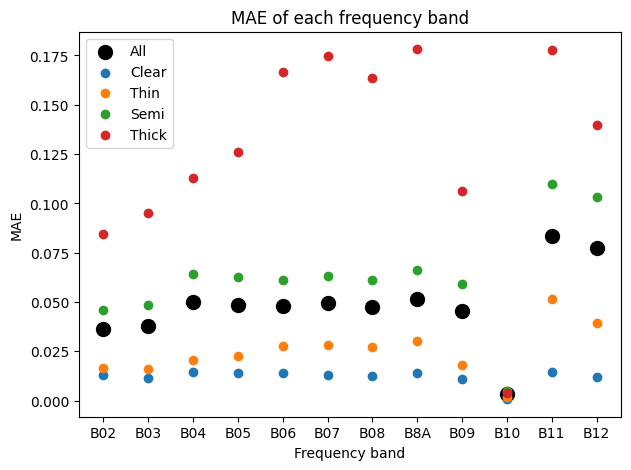

In [68]:
testindices=y_test.index
COTs=np.array(df['COT'].iloc[testindices])

thin=1.25
thick=50
#Divide into bins depending on COT
clear_true = y_test.to_numpy()[(COTs==0),:]
clear_pred = pred_y[(COTs==0),:,:]
thin_true = y_test.to_numpy()[(COTs>0) &  (COTs<thin),:]
thin_pred = pred_y[(COTs>0) & (COTs<thin),:,:]
semi_true = y_test.to_numpy()[(COTs>=thin) & (COTs<thick),:]
semi_pred = pred_y[(COTs>=thin) & (COTs<thick),:,:]
thick_true = y_test.to_numpy()[(COTs>=thick),:]
thick_pred = pred_y[(COTs>=thick),:,:]


#Find and print MAE of each band
MAE_col_tot = np.mean(np.abs(y_test.to_numpy()-pred_y[:,:,index_median]),axis=0)
MAE_col_clear = np.mean(np.abs(clear_true-clear_pred[:,:,index_median]),axis=0)
MAE_col_thin = np.mean(np.abs(thin_true-thin_pred[:,:,index_median]),axis=0)
MAE_col_semi = np.mean(np.abs(semi_true-semi_pred[:,:,index_median]),axis=0)
MAE_col_thick = np.mean(np.abs(thick_true-thick_pred[:,:,index_median]),axis=0)

x=np.arange(np.size(MAE_col_tot))
plt.rcParams["figure.figsize"] = [7, 5]
plt.figure()
plt.scatter(x,MAE_col_tot,c='black',s=100)
plt.scatter(x,MAE_col_clear)
plt.scatter(x,MAE_col_thin)
plt.scatter(x,MAE_col_semi)
plt.scatter(x,MAE_col_thick)
plt.xticks(x, ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
plt.title('MAE of each frequency band')
plt.xlabel('Frequency band')
plt.ylabel('MAE')
plt.legend(['All','Clear','Thin','Semi','Thick'])
plt.show()

In [69]:
np.shape(pred_y_11)

(20000, 3)

In [70]:
from matplotlib.patches import PathPatch
from matplotlib.path import Path

def draw_error_band(ax, x, y, err, **kwargs):
    # Calculate normals via centered finite differences (except the first point
    # which uses a forward difference and the last point which uses a backward
    # difference).
    dx = np.concatenate([[x[1] - x[0]], x[2:] - x[:-2], [x[-1] - x[-2]]])
    dy = np.concatenate([[y[1] - y[0]], y[2:] - y[:-2], [y[-1] - y[-2]]])
    l = np.hypot(dx, dy)
    nx = dy / l
    ny = -dx / l

    # end points of errors
    xp = x + nx * err
    yp = y + ny * err
    xn = x - nx * err
    yn = y - ny * err

    vertices = np.block([[xp, xn[::-1]],
                         [yp, yn[::-1]]]).T
    codes = np.full(len(vertices), Path.LINETO)
    codes[0] = codes[len(xp)] = Path.MOVETO
    path = Path(vertices, codes)
    ax.add_patch(PathPatch(path, **kwargs))

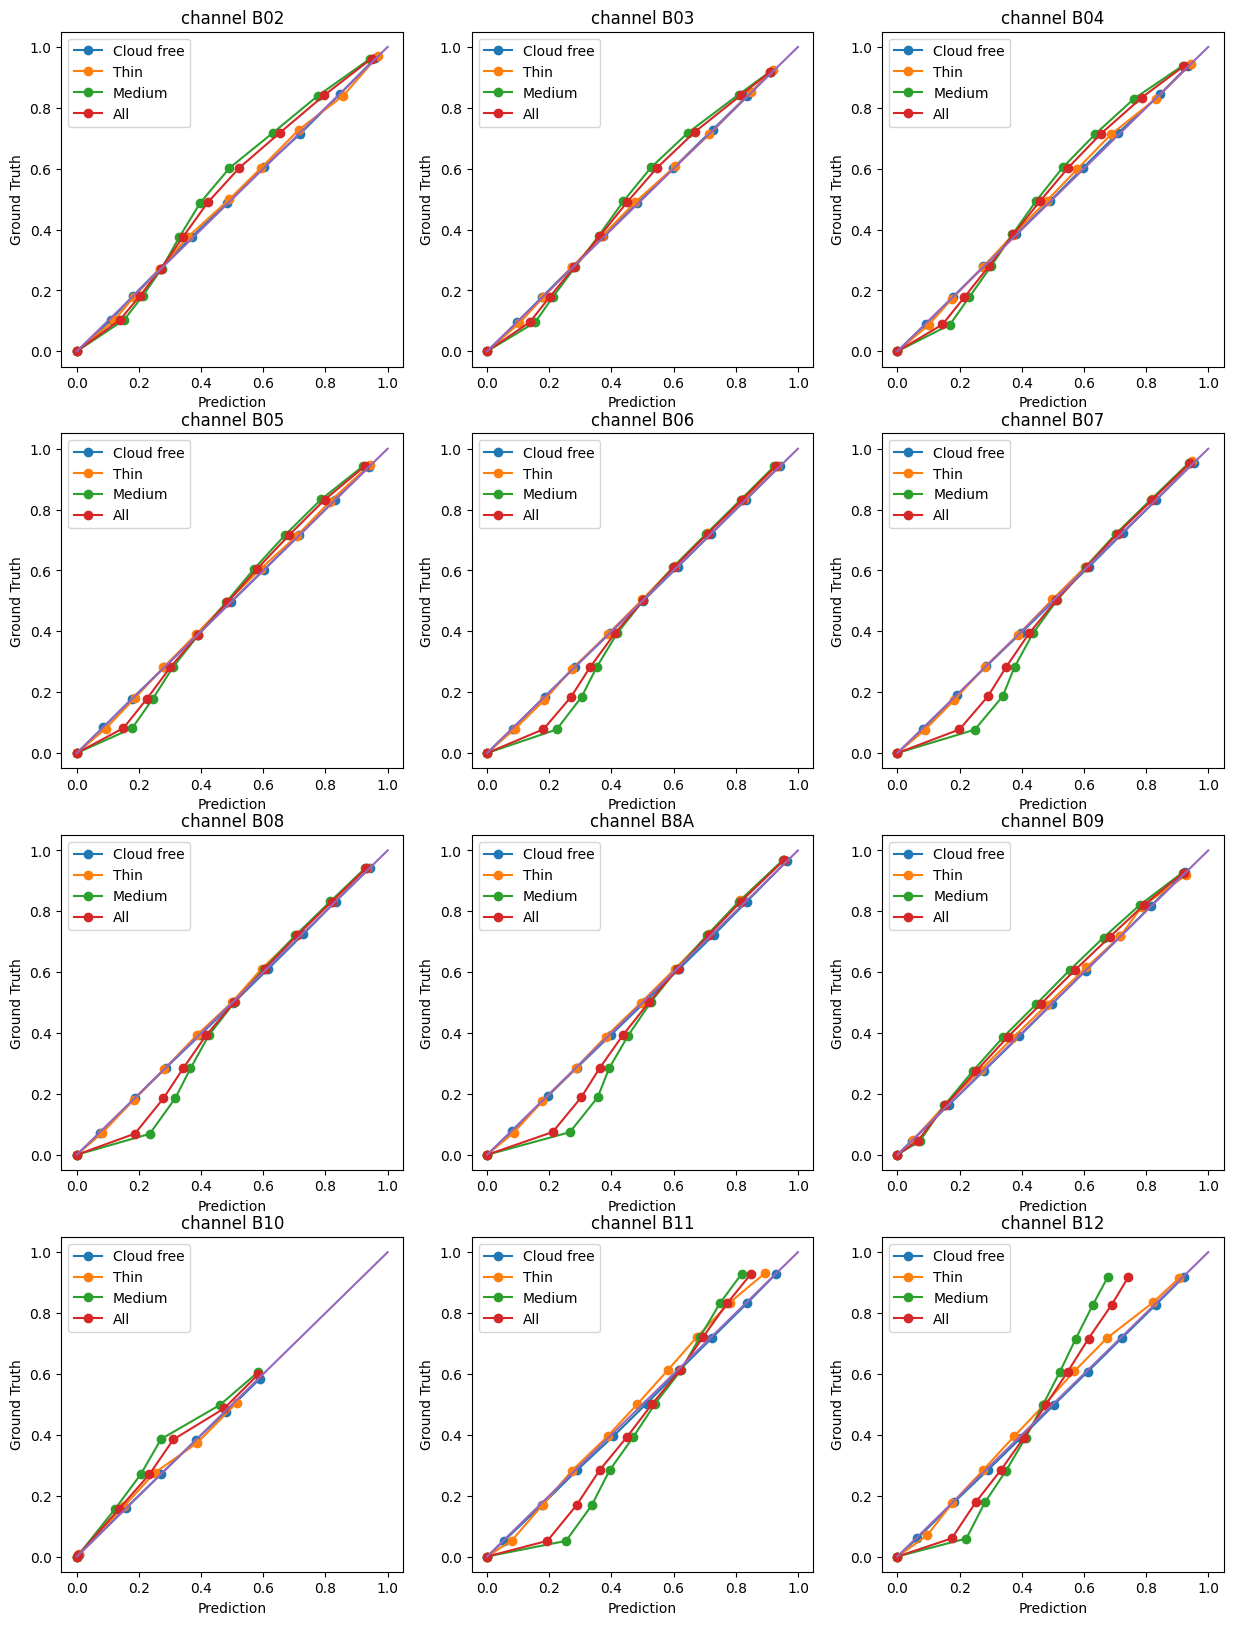

In [86]:
ncols=3
nrows=int(12/ncols)
plt.rcParams["figure.figsize"] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)


col_count=0
row_count=0
for i in range(12):
    band=i
    ## Prediction v Ground Truth ##
    y_true_11=y_test.to_numpy()[:,band]
    pred_y_11=pred_y[:,band]
    bins=np.linspace(0,1,10)

    freq_true=np.zeros(len(bins))
    freq_pred=np.zeros(len(bins))

    freq_true_zero=np.zeros(len(bins))
    freq_pred_zero=np.zeros(len(bins))

    freq_true_thin=np.zeros(len(bins))
    freq_pred_thin=np.zeros(len(bins))

    freq_true_med=np.zeros(len(bins))
    freq_pred_med=np.zeros(len(bins))

    y_tmp_zero=clear_true[:,band]
    y_tmp_thin=thin_true[:,band]
    y_tmp_med=semi_true[:,band]

    y_tmp_pred_zero=clear_pred[:,band]
    y_tmp_pred_thin=thin_pred[:,band]
    y_tmp_pred_med=semi_pred[:,band]

    for j,edge in enumerate(bins):
        if j!=0:
            indices=(y_true_11>bins[j-1])&(y_true_11<=edge)
            ind_z=(y_tmp_zero>bins[j-1])&(y_tmp_zero<=edge)
            ind_t=(y_tmp_thin>bins[j-1])&(y_tmp_thin<=edge)
            ind_m=(y_tmp_med>bins[j-1])&(y_tmp_med<=edge)

            mean_bin_true=np.mean(y_true_11[indices])
            mean_bin_pred=np.mean(pred_y_11[indices,index_median])

            mean_bin_true_zero=np.mean(y_tmp_zero[ind_z])
            mean_bin_pred_zero=np.mean(y_tmp_pred_zero[ind_z,index_median])

            mean_bin_true_thin=np.mean(y_tmp_thin[ind_t])
            mean_bin_pred_thin=np.mean(y_tmp_pred_thin[ind_t,index_median])

            mean_bin_true_med=np.mean(y_tmp_med[ind_m])
            mean_bin_pred_med=np.mean(y_tmp_pred_med[ind_m,index_median])
            
            freq_true[j]=mean_bin_true
            freq_pred[j]=mean_bin_pred


            freq_true_zero[j]=mean_bin_true_zero
            freq_pred_zero[j]=mean_bin_pred_zero

            freq_true_thin[j]=mean_bin_true_thin
            freq_pred_thin[j]=mean_bin_pred_thin

            freq_true_med[j]=mean_bin_true_med
            freq_pred_med[j]=mean_bin_pred_med


    if col_count==ncols:
        col_count=0
        row_count=row_count+1

    axs[row_count,col_count].plot(freq_pred_zero,freq_true_zero,'-o')
    axs[row_count,col_count].plot(freq_pred_thin,freq_true_thin,'-o')
    axs[row_count,col_count].plot(freq_pred_med,freq_true_med,'-o')
    axs[row_count,col_count].plot(freq_pred,freq_true,'-o')

    #plt.plot(cloudy_sort,'.')
    line=np.linspace(0,1,100)
    axs[row_count,col_count].plot(line,line)

    axs[row_count,col_count].legend(['Cloud free','Thin','Medium','All'])
    axs[row_count,col_count].set_xlabel("Prediction")
    axs[row_count,col_count].set_ylabel("Ground Truth")
    if i<7:
        axs[row_count,col_count].set_title("channel B0"+str(i+2))
    elif i==7:
        axs[row_count,col_count].set_title("channel B8A")
    elif i==8:
        axs[row_count,col_count].set_title("channel B09")
    else:
        axs[row_count,col_count].set_title("channel B"+str(i+1))
        

    col_count=col_count+1

#fig.suptitle('Ground truth vs prediction, filtered on COT')

Text(0.5, 0.98, 'Ground truth vs prediction, filtered on COT')

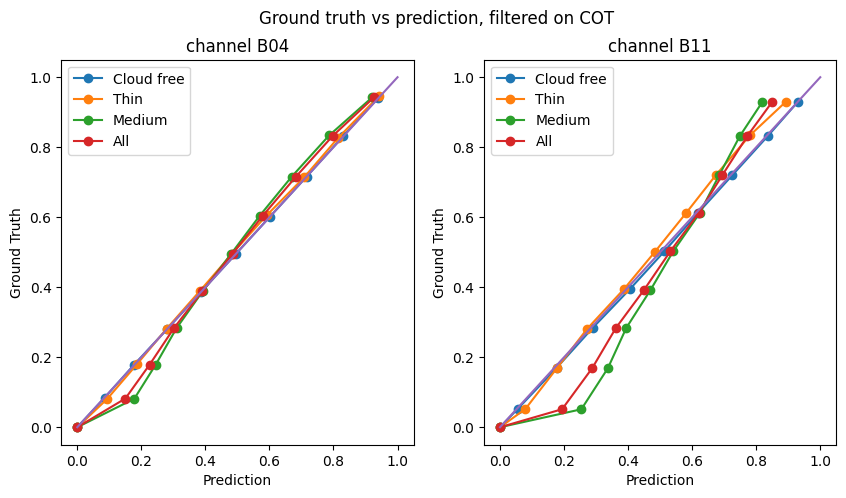

In [89]:
ncols=2
nrows=1
plt.rcParams["figure.figsize"] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)


col_count=0
row_count=0
for i in range(2):
    if i==0:
        band=3
    else:
        band=10
    ## Prediction v Ground Truth ##
    y_true_11=y_test.to_numpy()[:,band]
    pred_y_11=pred_y[:,band]
    bins=np.linspace(0,1,10)

    freq_true=np.zeros(len(bins))
    freq_pred=np.zeros(len(bins))

    freq_true_zero=np.zeros(len(bins))
    freq_pred_zero=np.zeros(len(bins))

    freq_true_thin=np.zeros(len(bins))
    freq_pred_thin=np.zeros(len(bins))

    freq_true_med=np.zeros(len(bins))
    freq_pred_med=np.zeros(len(bins))

    y_tmp_zero=clear_true[:,band]
    y_tmp_thin=thin_true[:,band]
    y_tmp_med=semi_true[:,band]

    y_tmp_pred_zero=clear_pred[:,band]
    y_tmp_pred_thin=thin_pred[:,band]
    y_tmp_pred_med=semi_pred[:,band]

    for j,edge in enumerate(bins):
        if j!=0:
            indices=(y_true_11>bins[j-1])&(y_true_11<=edge)
            ind_z=(y_tmp_zero>bins[j-1])&(y_tmp_zero<=edge)
            ind_t=(y_tmp_thin>bins[j-1])&(y_tmp_thin<=edge)
            ind_m=(y_tmp_med>bins[j-1])&(y_tmp_med<=edge)

            mean_bin_true=np.mean(y_true_11[indices])
            mean_bin_pred=np.mean(pred_y_11[indices,index_median])

            mean_bin_true_zero=np.mean(y_tmp_zero[ind_z])
            mean_bin_pred_zero=np.mean(y_tmp_pred_zero[ind_z,index_median])

            mean_bin_true_thin=np.mean(y_tmp_thin[ind_t])
            mean_bin_pred_thin=np.mean(y_tmp_pred_thin[ind_t,index_median])

            mean_bin_true_med=np.mean(y_tmp_med[ind_m])
            mean_bin_pred_med=np.mean(y_tmp_pred_med[ind_m,index_median])
            
            freq_true[j]=mean_bin_true
            freq_pred[j]=mean_bin_pred


            freq_true_zero[j]=mean_bin_true_zero
            freq_pred_zero[j]=mean_bin_pred_zero

            freq_true_thin[j]=mean_bin_true_thin
            freq_pred_thin[j]=mean_bin_pred_thin

            freq_true_med[j]=mean_bin_true_med
            freq_pred_med[j]=mean_bin_pred_med


    if col_count==ncols:
        col_count=0
        row_count=row_count+1

    axs[col_count].plot(freq_pred_zero,freq_true_zero,'-o')
    axs[col_count].plot(freq_pred_thin,freq_true_thin,'-o')
    axs[col_count].plot(freq_pred_med,freq_true_med,'-o')
    axs[col_count].plot(freq_pred,freq_true,'-o')

    #plt.plot(cloudy_sort,'.')
    line=np.linspace(0,1,100)
    axs[col_count].plot(line,line)

    axs[col_count].legend(['Cloud free','Thin','Medium','All'])
    axs[col_count].set_xlabel("Prediction")
    axs[col_count].set_ylabel("Ground Truth")
    if i==0:
        axs[col_count].set_title("channel B04")
    else:
        axs[col_count].set_title("channel B11")

    col_count=col_count+1

fig.suptitle('Ground truth vs prediction, filtered on COT')

Text(0.5, 1.0, 'Ground truth over prediction, channel 11, different COT')

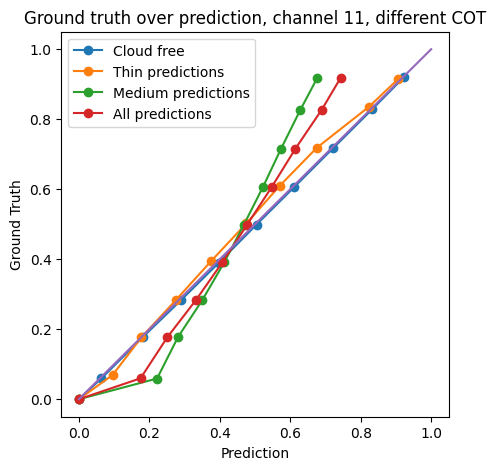

In [72]:
plt.rcParams["figure.figsize"] = [5, 5]
plt.plot(freq_pred_zero,freq_true_zero,'-o')
plt.plot(freq_pred_thin,freq_true_thin,'-o')
plt.plot(freq_pred_med,freq_true_med,'-o')
plt.plot(freq_pred,freq_true,'-o')

#plt.plot(cloudy_sort,'.')
line=np.linspace(0,1,100)
plt.plot(line,line)

plt.legend(['Cloud free','Thin predictions','Medium predictions','All predictions'])
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")
plt.title("Ground truth over prediction, channel 11, different COT")

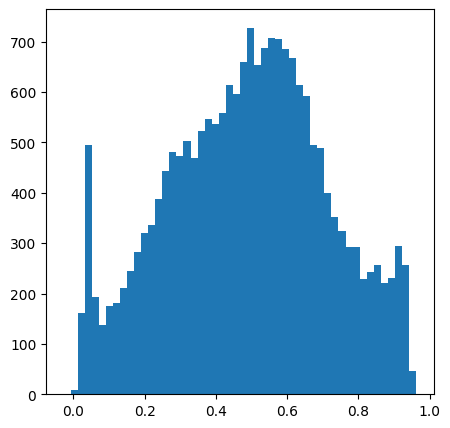

In [28]:
plt.rcParams["figure.figsize"] = [5, 5]
plt.hist(pred_y_11[:,0],bins=50)
plt.show()

In [29]:
#np.mean(pred_y_7[:,4])

In [30]:
#plt.hist(pred_y_7[:,4],alpha=0.7)
#plt.hist(y_test['Clear_B05'],alpha=0.7)

In [31]:
MSE=[]
R2=[]
PSNR=[]
quantrates=[]
quantcross=[]

MSE.append(mean_squared_error(y_true,pred_y[:,:,index_median]))
R2.append(r2_score(y_true,pred_y[:,:,index_median]))
PSNR.append(calc_metrics.PSNR(y_true,pred_y[:,:,index_median]))
quantrates.append(calc_metrics.quant_rate(y_true,pred_y))
quantcross.append(calc_metrics.quant_cross(pred_y))

In [32]:

print("MSE: "+str(MSE[0]))
print(" ")
print("R2 score: "+str(R2[0]))
print(" ")

print("PSNR: "+str(PSNR[0]))
print(" ")
print("Quantrate: "+str(quantrates[0]))
print(" ")
print("Quantile crossing: "+str(quantcross[0]))

MSE: 0.007037604842913779
 
R2 score: 0.8171892878379783
 
PSNR: 21.556779033880055
 
Quantrate: [0.11689583 0.50964167 0.88603333]
 
Quantile crossing: 0.0


In [33]:
test_indices=X_test.index
df_test=df.loc[test_indices]
df_test=df_test.reset_index()
df_test_clear=df_test[df_test['COT']==0]
df_test_thin=df_test[(df_test['COT']<=3.6) & (df_test['COT']>0)]
df_test_med=df_test[(df_test['COT']<=23) & (df_test['COT']>3.6)]
df_test_thick=df_test[(df_test['COT']<=50) & (df_test['COT']>23)]

In [34]:


MSE_cot_levels=[]
MSE_cot_levels.append(mean_squared_error(y_true,pred_y[:,:,index_median]))
MSE_cot_levels.append(mean_squared_error(y_true[df_test_clear.index],pred_y[df_test_clear.index,:,index_median]))
MSE_cot_levels.append(mean_squared_error(y_true[df_test_thin.index],pred_y[df_test_thin.index,:,index_median]))
MSE_cot_levels.append(mean_squared_error(y_true[df_test_med.index],pred_y[df_test_med.index,:,index_median]))
MSE_cot_levels.append(mean_squared_error(y_true[df_test_thick.index],pred_y[df_test_thick.index,:,index_median]))

In [35]:
print("MSE all test data: "+str(MSE_cot_levels[0]))
print("MSE clear test data: "+str(MSE_cot_levels[1]))
print("MSE thin COT <3.6 test data: "+str(MSE_cot_levels[2]))
print("MSE med COT <23 test data: "+str(MSE_cot_levels[3]))
print("MSE thick COT <50 test data: "+str(MSE_cot_levels[4]))

MSE all test data: 0.007037604842913779
MSE clear test data: 0.00035895594811405986
MSE thin COT <3.6 test data: 0.002096972431452957
MSE med COT <23 test data: 0.005836145668260805
MSE thick COT <50 test data: 0.01709099079739201


In [36]:
y_clear=y_true[df_test_clear.index]
y_pred_clear=pred_y[df_test_clear.index,:,index_median]

In [37]:
norm_og=np.linalg.norm((y_clear)-(y_clear),axis=0)**2
norm_pred=np.linalg.norm((y_clear)-y_pred_clear,axis=0)**2
norm_gt=np.linalg.norm(y_clear,axis=0)**2

NMSE_og=norm_og/norm_gt
NMSE_pred=norm_pred/norm_gt

NMSE_og_wo_10=np.concatenate((NMSE_og[0:9],NMSE_og[10:]),axis=0)
NMSE_pred_wo_10=np.concatenate((NMSE_pred[0:9],NMSE_pred[10:]),axis=0)


In [38]:
NMSE_pred_wo_10

array([0.00285718, 0.0020467 , 0.00231156, 0.00160125, 0.00099587,
       0.00086267, 0.00081733, 0.00095314, 0.0024736 , 0.00157915,
       0.00180304])

In [39]:
for i in range(len(NMSE_og)):
    if i<=6:
        print('NMSE before correction, Band '+str(i+2)+': '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+2)+': '+str(np.round(NMSE_pred[i],5)))
    elif i==7:
        print('NMSE before correction, Band '+str(i+1)+'A: '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+'A: '+str(np.round(NMSE_pred[i],5)))
    else:
        print('NMSE before correction, Band '+str(i+1)+': '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+': '+str(np.round(NMSE_pred[i],5)))    

    print(' ')
print('Mean NMSE before correction: '+str(np.round(np.mean(NMSE_og),5)))
print('Mean NMSE after correction: '+str(np.round(np.mean(NMSE_pred),5)))  

print(' ')
print('Mean NMSE before correction, without band 10: '+str(np.mean(NMSE_og_wo_10)))
print('Mean NMSE after correction, without band 10: '+str(np.round(np.mean(NMSE_pred_wo_10),4))) 

NMSE before correction, Band 2: 0.0
NMSE after correction, Band 2: 0.00286
 
NMSE before correction, Band 3: 0.0
NMSE after correction, Band 3: 0.00205
 
NMSE before correction, Band 4: 0.0
NMSE after correction, Band 4: 0.00231
 
NMSE before correction, Band 5: 0.0
NMSE after correction, Band 5: 0.0016
 
NMSE before correction, Band 6: 0.0
NMSE after correction, Band 6: 0.001
 
NMSE before correction, Band 7: 0.0
NMSE after correction, Band 7: 0.00086
 
NMSE before correction, Band 8: 0.0
NMSE after correction, Band 8: 0.00082
 
NMSE before correction, Band 8A: 0.0
NMSE after correction, Band 8A: 0.00095
 
NMSE before correction, Band 9: 0.0
NMSE after correction, Band 9: 0.00247
 
NMSE before correction, Band 10: 0.0
NMSE after correction, Band 10: 0.00166
 
NMSE before correction, Band 11: 0.0
NMSE after correction, Band 11: 0.00158
 
NMSE before correction, Band 12: 0.0
NMSE after correction, Band 12: 0.0018
 
Mean NMSE before correction: 0.0
Mean NMSE after correction: 0.00166
 
M

## Spectrum comparison

In [40]:
cloudy_columns=['Cloud_B02', 'Cloud_B03', 'Cloud_B04', 'Cloud_B05',
                'Cloud_B06', 'Cloud_B07', 'Cloud_B08', 'Cloud_B09', 'Cloud_B10',
                'Cloud_B11', 'Cloud_B12', 'Cloud_B13']

clear_columns=['Clear_B02','Clear_B03', 'Clear_B04', 
               'Clear_B05', 'Clear_B06', 'Clear_B07','Clear_B08', 
               'Clear_B09', 'Clear_B10', 'Clear_B11', 'Clear_B12',
                'Clear_B13']

channel_columns=['Cloud_B02', 'Cloud_B03', 'Cloud_B04', 'Cloud_B05',
                'Cloud_B06', 'Cloud_B07', 'Cloud_B08', 'Cloud_B09', 'Cloud_B10',
                'Cloud_B11', 'Cloud_B12', 'Cloud_B13',
                'Clear_B02','Clear_B03', 'Clear_B04', 
                'Clear_B05', 'Clear_B06', 'Clear_B07','Clear_B08', 
                'Clear_B09', 'Clear_B10', 'Clear_B11', 'Clear_B12',
                'Clear_B13']

In [41]:
cloud_types=[ 'Stratus Continental', 'Stratus Maritime', 
             'Cumulus Continental Clean', 'Cumulus Continental Polluted', 
             'Cumulus Maritime', 'Cirrus']

In [42]:
channels=['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12']

df_veg=df_test[df_test['Surface_Desc_Dumb']=='vegetation']
df_veg=df_veg[df_veg['Cloud_Type']<=6]
mean_cot=10
df_veg=df_veg[(df_veg['COT']>(mean_cot-1)) & (df_veg['COT']<(mean_cot+1))]
sample=df_veg.iloc[0]


plt.rcParams["figure.figsize"] = [7, 5]
plt.plot(channels,sample[cloudy_columns].to_numpy(),'-o')
plt.plot(channels,sample[clear_columns].to_numpy(),'-o')
plt.legend(['cloudy','clear'])
plt.show()

IndexError: single positional indexer is out-of-bounds

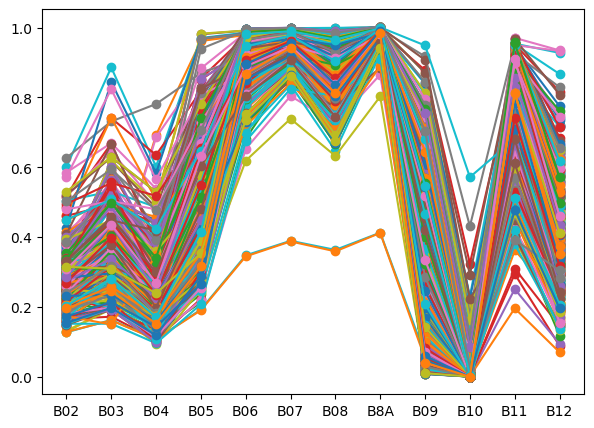

In [ ]:
plt.rcParams["figure.figsize"] = [7, 5]
#plt.plot(channels,df_veg[cloudy_columns].to_numpy().T,'-o')
plt.plot(channels,df_veg[clear_columns].to_numpy().T,'-o')
plt.show()

In [ ]:
sample_point=df_veg.iloc[0][clear_columns]
diff=np.mean(np.abs(df_veg[clear_columns]-sample_point),axis=1)
threshold=0.03
mask=diff<=threshold
df_veg_sim=df_veg[mask]

In [ ]:
len(df_veg_sim)

3

In [ ]:
df_veg_sim.Cloud_Type.value_counts()

Cloud_Type
6    3
Name: count, dtype: int64

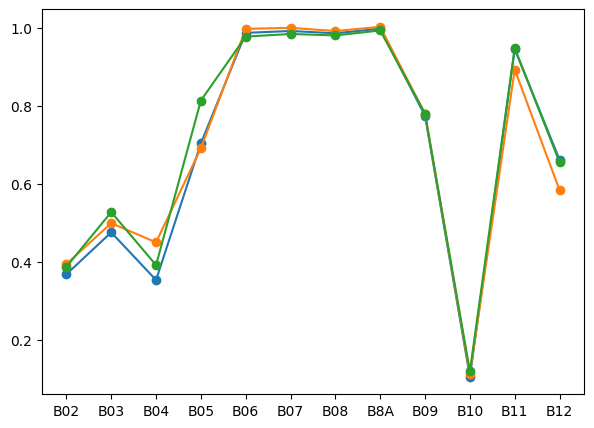

In [ ]:
plt.rcParams["figure.figsize"] = [7, 5]
#plt.plot(channels,df_veg[cloudy_columns].to_numpy().T,'-o')
plt.plot(channels,df_veg_sim[clear_columns].to_numpy().T,'-o')
plt.show()

In [ ]:
np.shape(pred_y)

(20000, 12, 9)

In [ ]:
df_tmp.index[0]

0

Text(0.5, 0.98, 'Black surface vegetation, COT = 10')

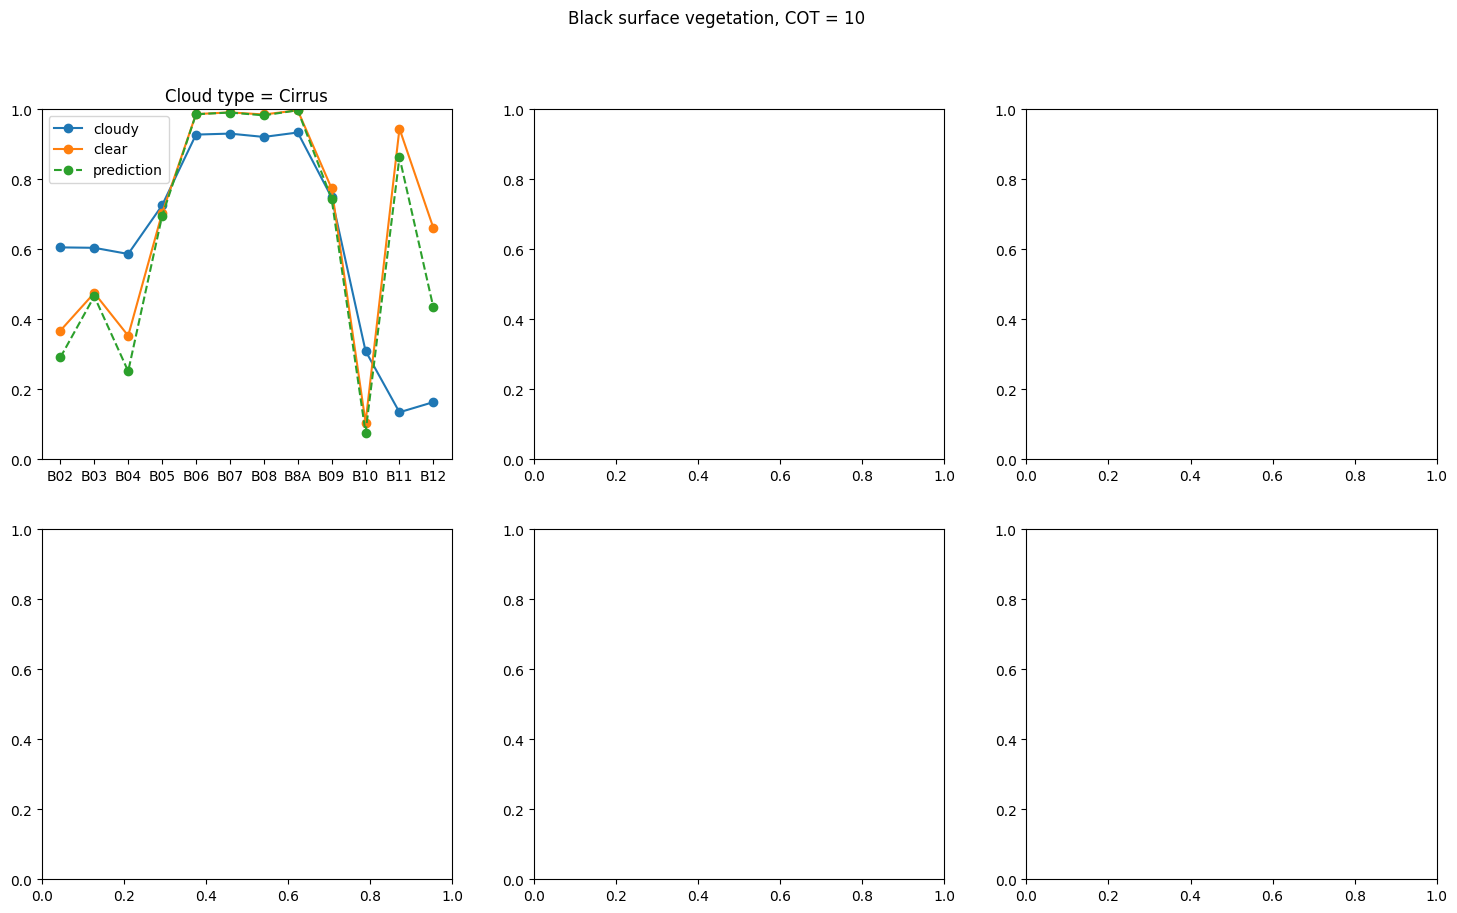

In [ ]:
nrows=2
ncols=3

plt.rcParams["figure.figsize"] = [6*ncols, 5*nrows]

fig,axs=plt.subplots(ncols=ncols,nrows=nrows)
for i,c_type in enumerate(np.sort(df_veg_sim.Cloud_Type.unique())):
    if i<3:
        df_tmp=df_veg_sim[df_veg_sim['Cloud_Type']==c_type]
        prediction=pred_y[df_tmp.index[0],:,index_median]
        sample=df_tmp.iloc[0]
        axs[0,i].plot(channels,sample[cloudy_columns],'-o')
        axs[0,i].plot(channels,sample[clear_columns],'-o')
        axs[0,i].plot(channels,prediction,'--o')
        axs[0,i].set_ylim([0,1])
        axs[0,i].legend(['cloudy','clear','prediction'])
        axs[0,i].set_title('Cloud type = '+cloud_types[c_type-1])
    else:
        df_tmp=df_veg[df_veg['Cloud_Type']==c_type]
        prediction=pred_y[df_tmp.index[0],:,index_median]
        sample=df_tmp.iloc[0]
        axs[1,i-3].plot(channels,sample[cloudy_columns],'-o')
        axs[1,i-3].plot(channels,sample[clear_columns],'-o')
        axs[1,i-3].plot(channels,prediction,'--o')
        axs[1,i-3].set_ylim([0,1])
        axs[1,i-3].legend(['cloudy','clear','prediction'])
        axs[1,i-3].set_title('Cloud type = '+cloud_types[c_type-1])
fig.suptitle('Black surface vegetation, COT = '+str(mean_cot))

In [ ]:
df_test.columns

Index(['index', 'Cloud_B02', 'Cloud_B03', 'Cloud_B04', 'Cloud_B05',
       'Cloud_B06', 'Cloud_B07', 'Cloud_B08', 'Cloud_B09', 'Cloud_B10',
       'Cloud_B11', 'Cloud_B12', 'Cloud_B13', 'Clear_B02', 'Clear_B03',
       'Clear_B04', 'Clear_B05', 'Clear_B06', 'Clear_B07', 'Clear_B08',
       'Clear_B09', 'Clear_B10', 'Clear_B11', 'Clear_B12', 'Clear_B13',
       'Sat_Zenith_Angle', 'Sun_Zenith_Angle', 'Azimuth_Diff_Angle', 'COT',
       'Cloud_Type', 'Profile_ID', 'GOT', 'Water_Vapor', 'Surface_Desc',
       'Surface_Desc_Dumb'],
      dtype='object')

In [ ]:
df_test

,index,Cloud_B02,Cloud_B03,Cloud_B04,Cloud_B05,Cloud_B06,Cloud_B07,Cloud_B08,Cloud_B09,Cloud_B10,...,Sat_Zenith_Angle,Sun_Zenith_Angle,Azimuth_Diff_Angle,COT,Cloud_Type,Profile_ID,GOT,Water_Vapor,Surface_Desc,Surface_Desc_Dumb
0,117388,0.82452,0.79649,0.86598,0.85095,0.87185,0.89594,0.82931,0.90391,0.52308,...,1.49,56.89,162.86,31.986,6,7580,0.126,2.60,water-frost-none,water
1,141493,0.71389,0.74629,0.89357,0.90183,0.92112,0.93500,0.88953,0.94322,0.63586,...,2.89,58.97,1.61,13.338,6,4004,0.103,0.70,water-ice-none,water
2,40561,0.35329,0.31978,0.32267,0.31444,0.50948,0.62602,0.52055,0.68484,0.01028,...,2.40,76.18,156.46,4.413,3,8169,0.128,6.16,water-snow-mediumgranular,water
3,106710,0.58522,0.57080,0.67497,0.71686,0.85890,0.89755,0.82335,0.91772,0.35540,...,2.25,63.98,99.37,8.607,6,1949,0.126,1.68,water-frost-none,water
4,46013,0.51125,0.37154,0.41055,0.41800,0.46292,0.49839,0.45799,0.51827,0.09394,...,9.81,84.61,75.92,35.764,4,4850,0.126,2.18,water-snow-mediumgranular,water
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,3812,0.33307,0.35745,0.44083,0.50160,0.71643,0.82236,0.79592,0.89510,0.19037,...,5.97,67.51,0.34,0.472,1,2491,0.125,1.45,water-frost-none,water
19996,137904,0.73794,0.70470,0.72927,0.74198,0.78092,0.80467,0.77438,0.82495,0.63160,...,1.55,44.00,40.97,22.726,6,8915,0.125,6.11,water-snow-finegranular,water
19997,89892,0.24315,0.29530,0.35546,0.45270,0.61840,0.67567,0.69000,0.73230,0.42072,...,8.61,41.70,151.73,0.000,0,1027,0.126,0.44,water-snow-finegranular,water
19998,90164,0.21581,0.26947,0.47615,0.55758,0.70670,0.80615,0.78386,0.90142,0.15926,...,9.28,49.49,120.69,0.000,0,4284,0.125,2.60,water-snow-coarsegranular,water


In [ ]:
np.mean((df_test['Clear_B09']-df_test['Clear_B12'])/(df_test['Clear_B09']+df_test['Clear_B12']))

0.06612023658560652